`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [27]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
import statistics as stat

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# Import and regrid `gn` models

In [3]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [4]:
dd_new_gn = merge_variables(dset_dict_old_gn)
# list(dd_new.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon.gn.none.thetao failed to combine with :indexes along dimension 'lev' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r2i1p1f2.Omon.gn.none.thetao failed to combine with :cannot compare cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r10i1p1f1.Omon.gn.none.dissic failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) 

In [5]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_new_new_gn = combine_datasets(
    dd_new_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gn.keys())

['IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [6]:
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
# regridder = xe.Regridder(dd_new_new, targetgrid_ds, 'bilinear', 
#                          periodic=True, ignore_degenerate=True)

dd_regrid={}
for name,item in dd_new_new_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item)
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

# Import `gr` models

In [7]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [8]:
dd_new_gr = merge_variables(dset_dict_old_gr)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none.thetao failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none.so failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCAR.CESM2.historical.r10i1p1f1.Omon.gr.none.thetao failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/p

In [9]:
temp={}
for name,item in dd_new_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new_gr = temp
list(dd_new_gr.keys())

['CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r3i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'CESM2.gr.historical.Omon.r6i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1']

In [10]:
dd_new_new_gr = combine_datasets(
    dd_new_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gr.keys())

['CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon']

# Combine those two dictionaries

In [11]:
dd_new_new = {**dd_new_new_gr, **dd_regrid}
list(dd_new_new.keys())

['CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

# DIC

## 0m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

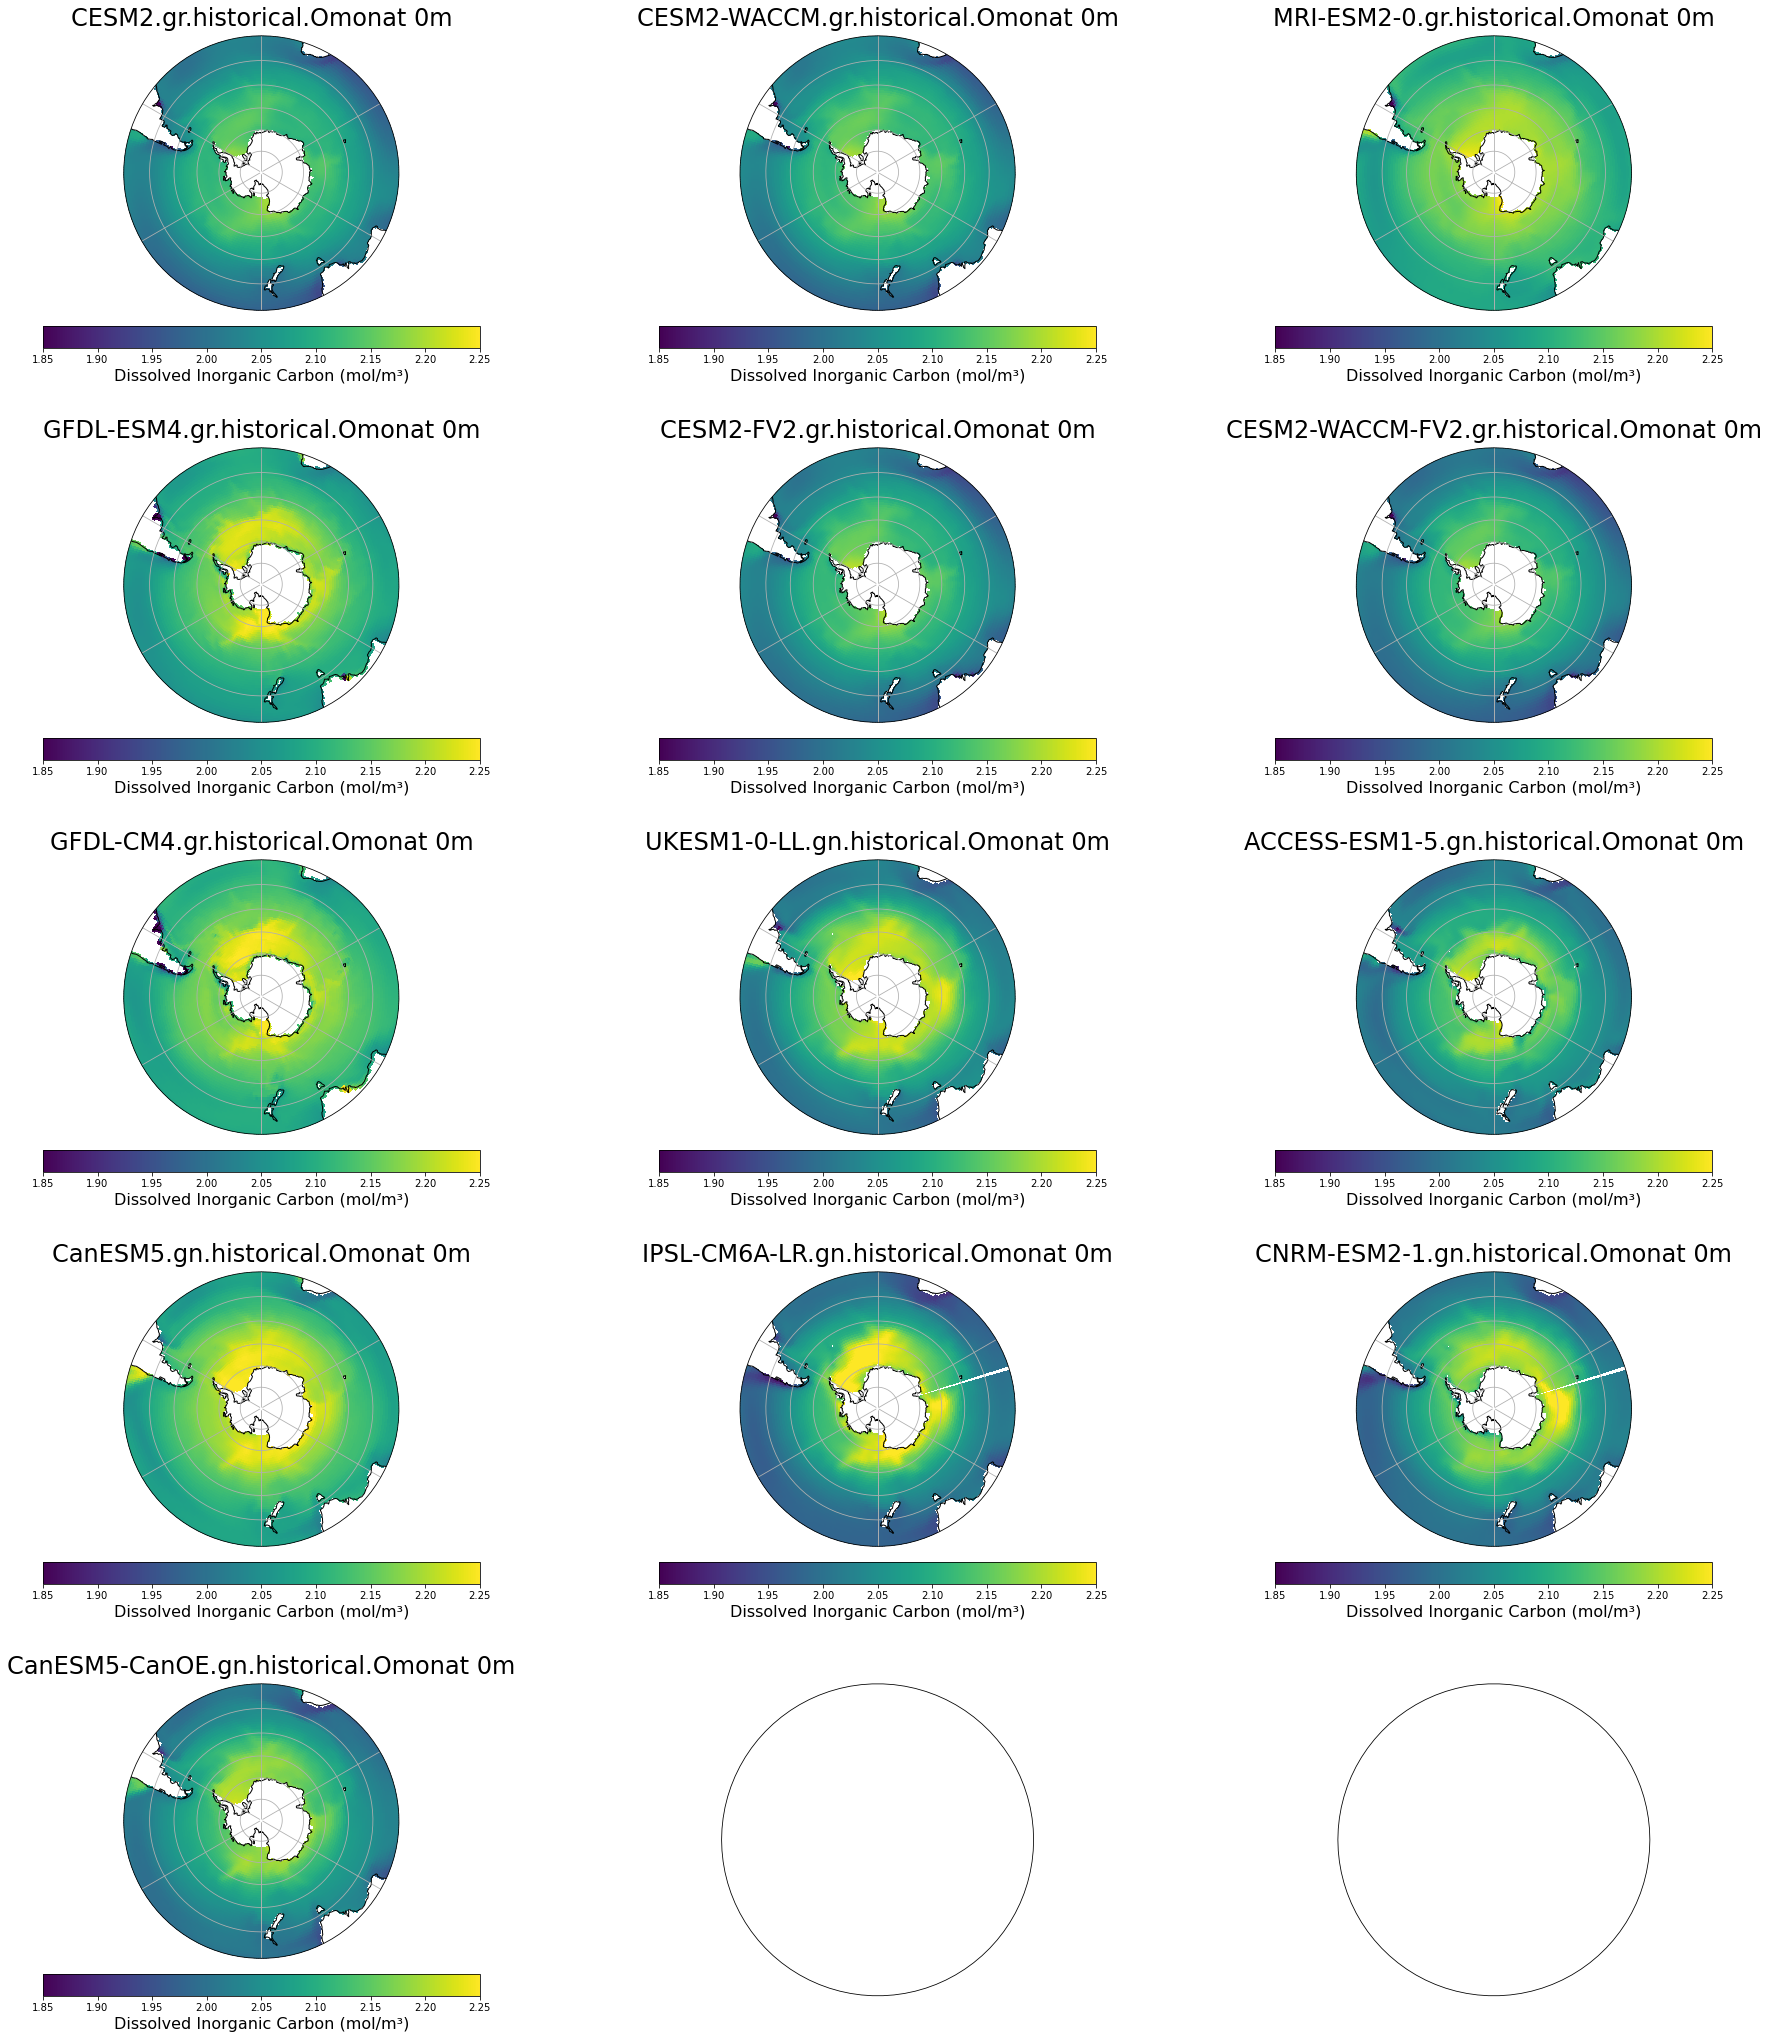

In [13]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 0m'
    ax.set_title(title,fontsize=24,pad = 10)
    
    
    Z = ds.dissic.isel(time = slice(0, 239), lev = 0).mean('time', keep_attrs=True)
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 1.85, vmax = 2.25)
    
    cbar_label = 'Dissolved Inorganic Carbon (mol/m\u00b3)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 16)
    
    ax_idx += 1

## 100m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

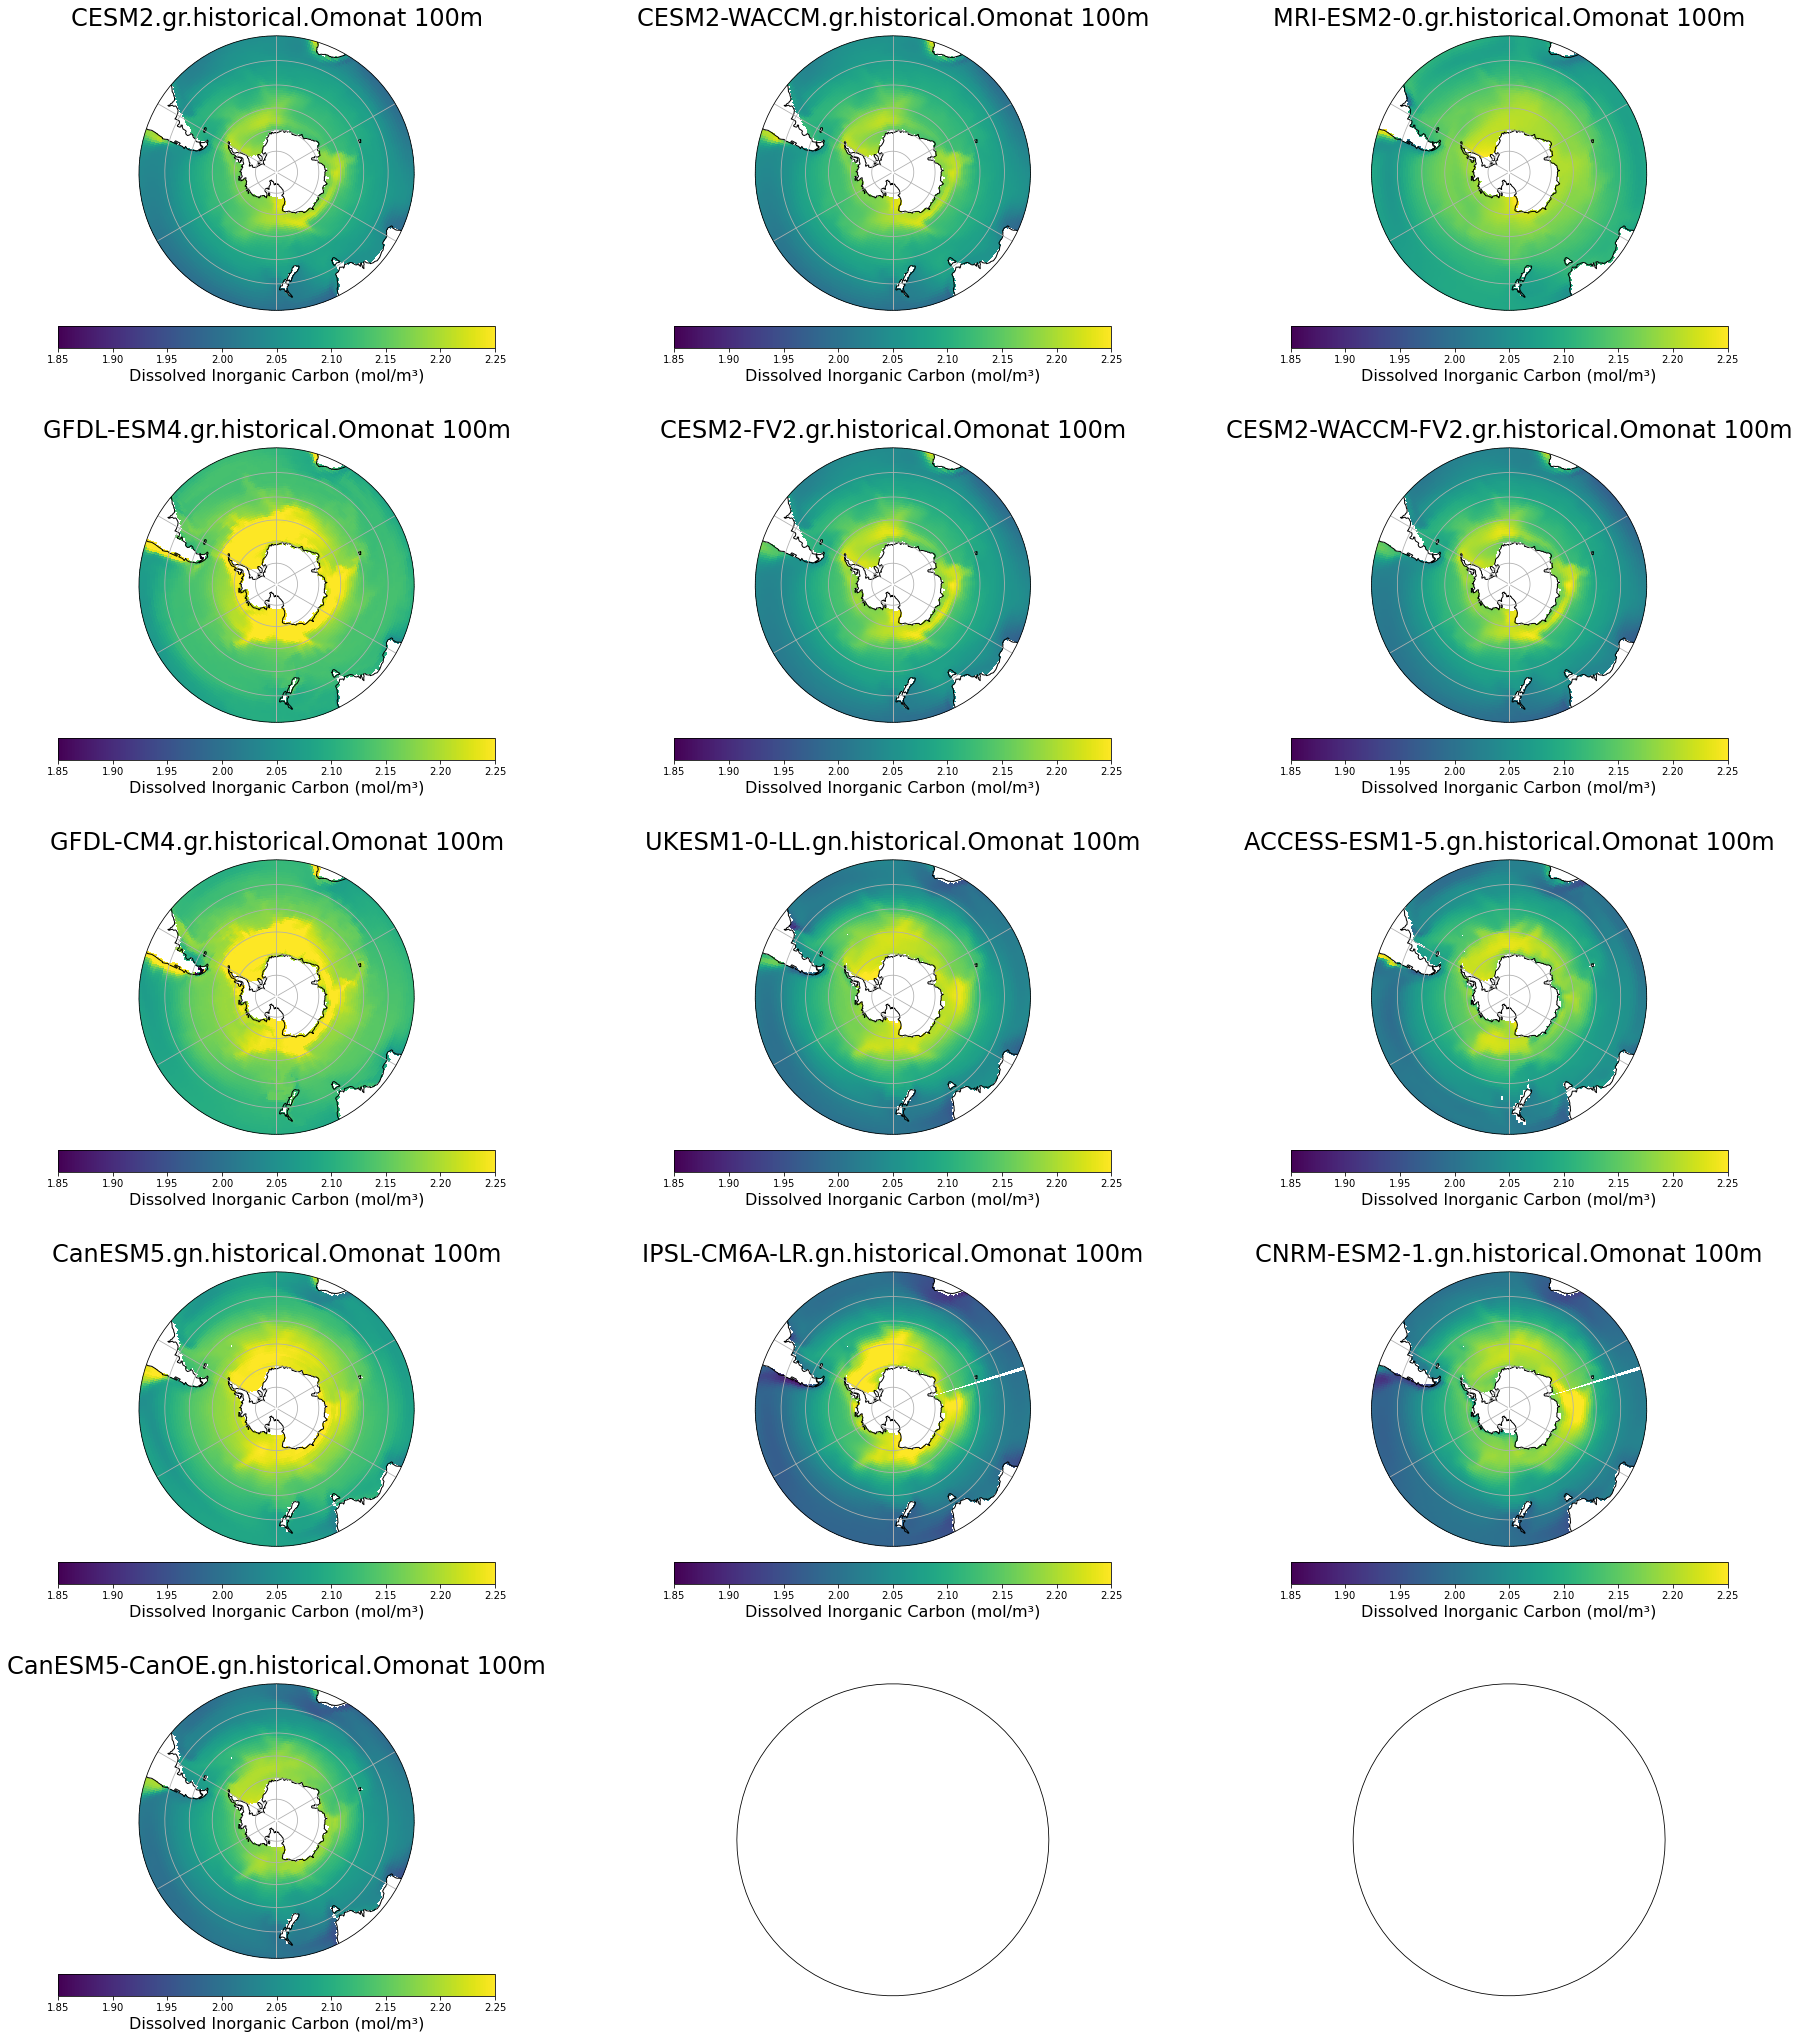

In [14]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 100m'
    ax.set_title(title,fontsize=24,pad = 10)
    
    
    Z = ds.dissic.isel(time = slice(0, 239), lev = 6).mean('time', keep_attrs=True)
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 1.85, vmax = 2.25)
    
    cbar_label = 'Dissolved Inorganic Carbon (mol/m\u00b3)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 16)
    
    ax_idx += 1

## 200m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

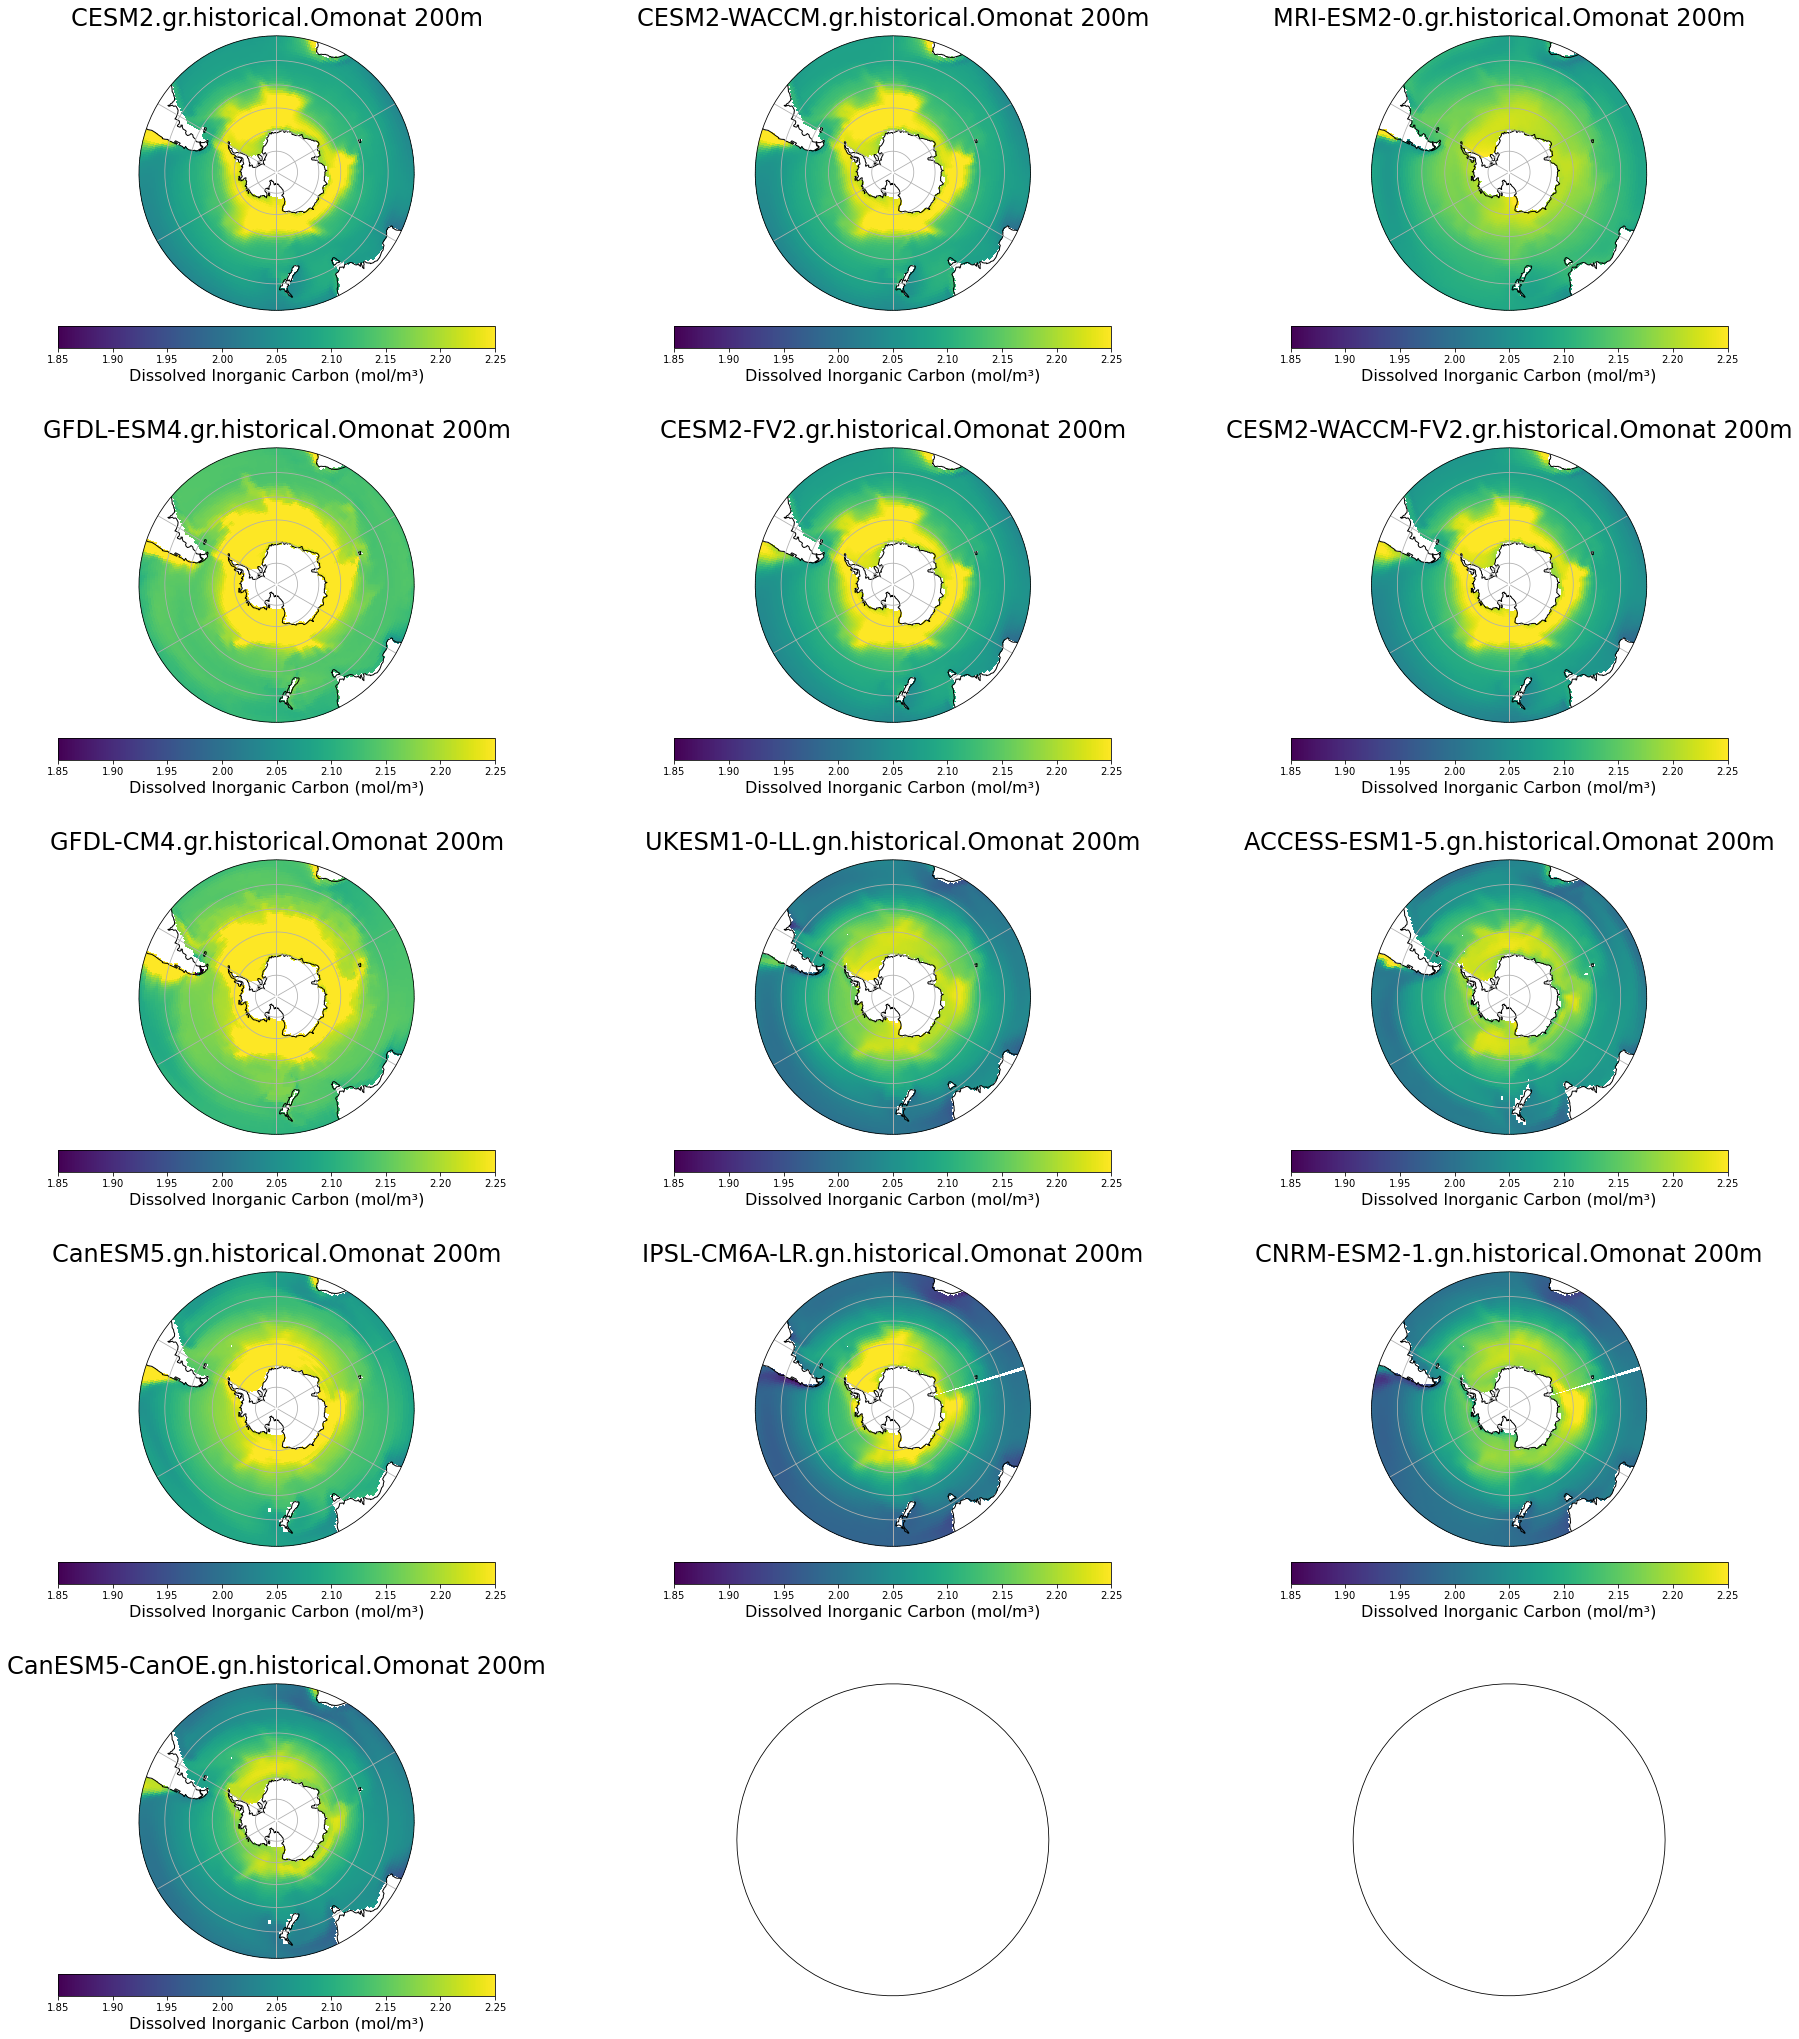

In [15]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 200m'
    ax.set_title(title,fontsize=24,pad = 10)
    
    
    Z = ds.dissic.isel(time = slice(0, 239), lev = 9).mean('time', keep_attrs=True)
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 1.85, vmax = 2.25)
    
    cbar_label = 'Dissolved Inorganic Carbon (mol/m\u00b3)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 16)
    
    ax_idx += 1

## 800m

In [ ]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 800m'
    ax.set_title(title,fontsize=24,pad = 10)
    
    
    Z = ds.dissic.isel(time = slice(0, 239), lev = 16).mean('time', keep_attrs=True)
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 1.85, vmax = 2.25)
    
    cbar_label = 'Dissolved Inorganic Carbon (mol/m\u00b3)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 16)
    
    ax_idx += 1

# Fgco2

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

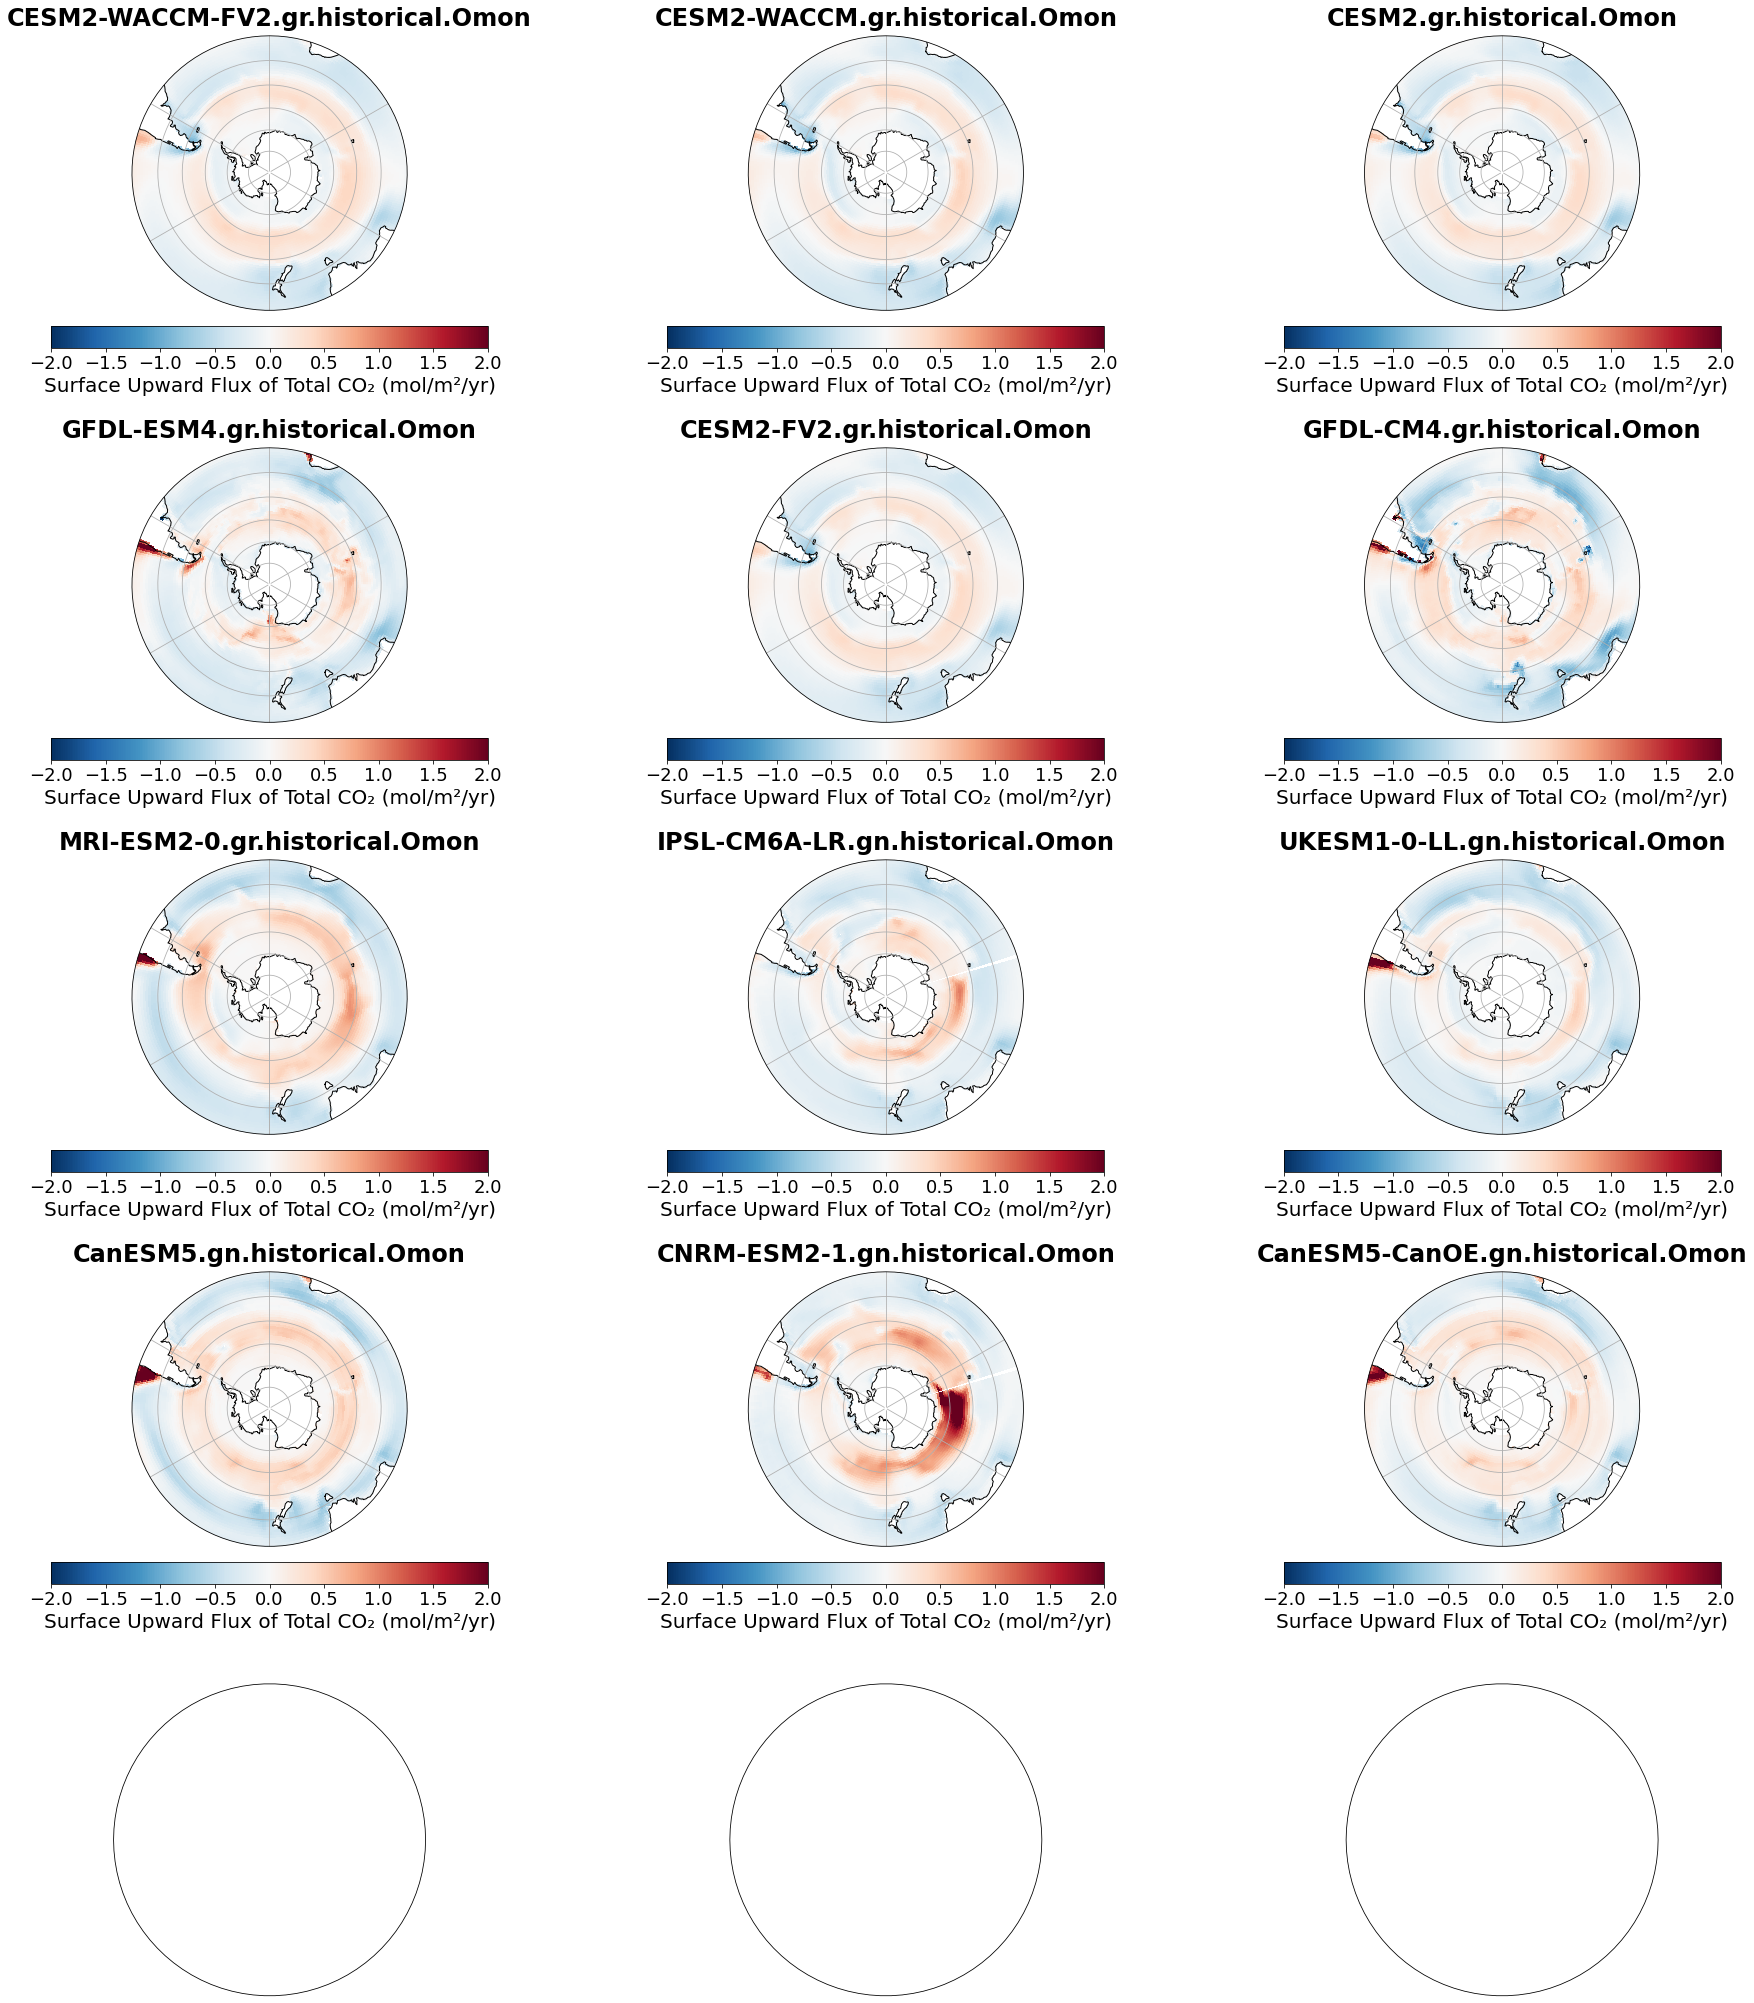

In [21]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=24,pad = 10, fontweight = 'bold')
    
    conversion = 3.1536e7 * 22.72
    # 3.1536e7 seconds per year
    # 22.72 mol CO2 per kg -- 44.01 gCO2/mol
    Z = ds.fgco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)*conversion
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -2, vmax = 2)
    
    cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=18)
    
    ax_idx += 1

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

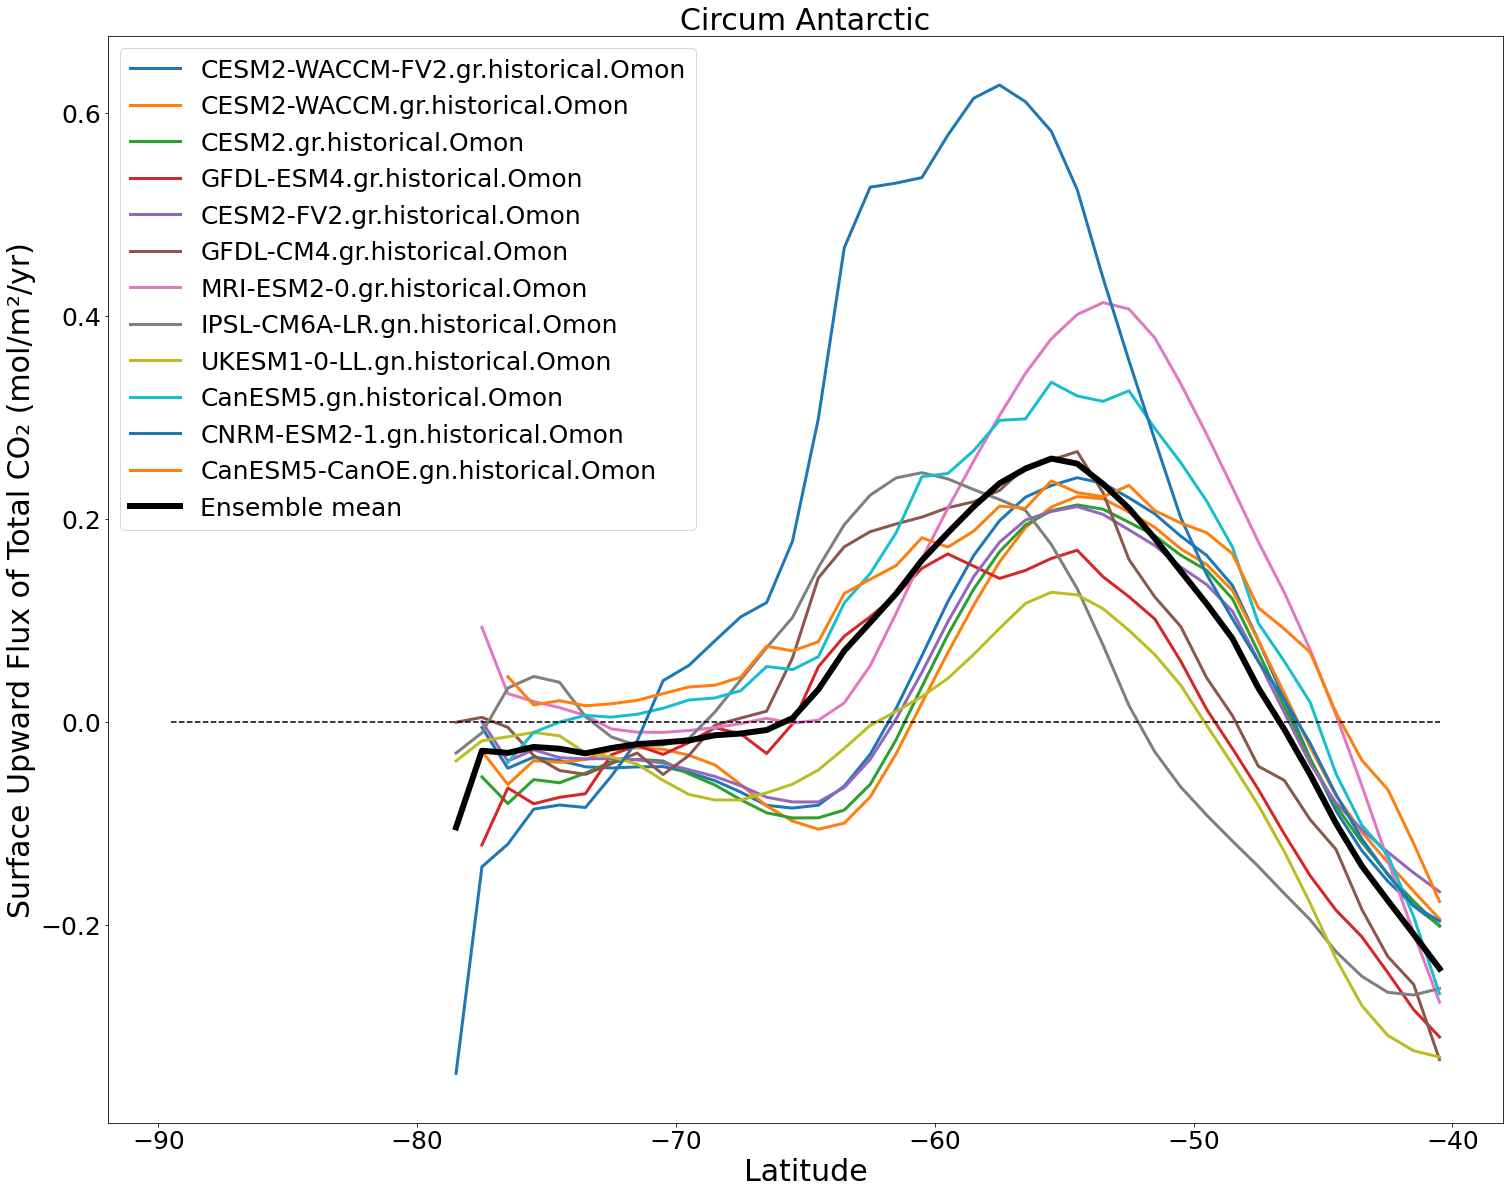

In [25]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 25)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}
yy = dd_new_new['CESM2-FV2.gr.historical.Omon'].lat.y

conversion = 3.1536e7 * 22.72
# 3.1536e7 seconds per year
# 22.72 mol CO2 per kg -- 44.01 gCO2/mol

ax_idx = 0
for name, ds in dd_new_new.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)*conversion
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
    plt.plot(yy[0:50], ar[0:50], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# ax = plt.gca
# box = ax.get_position()
# ax.position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper left'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic')
plt.rcParams["figure.figsize"] = (25,20)



In [31]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
plt.rc('font', size = 25)
plt.rc('axes', titlesize= 30)    
plt.rc('axes', labelsize= 30)
plt.rc('figure', titlesize=30)
temp={}
yy = dd_new_new['CESM2-FV2.gr.historical.Omon'].lat.y

conversion = 3.1536e7 * 22.72
# 3.1536e7 seconds per year
# 22.72 mol CO2 per kg -- 44.01 gCO2/mol

ax_idx = 0
for name, ds in dd_new_new.items():
    # maybe do mean over the entire circumference so just 
    # take out the where function and mean all x
    ar = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)*conversion
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
#     plt.plot(yy[0:50], ar[0:50], label = name, lw = 3)
    # adds ar to an array 
    temp[name] = ar
#     print(ds.fgco2.lat.y)
#     plt.xlabel('Latitude')
#     plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')


mn = np.nanmean(list(temp.values()), axis=0)
sd = np.std(list(temp.values()))
# plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

# zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
# plt.legend(
# #     bbox_to_anchor=(1.05, 1), 
#     loc='upper left'
# #     , borderaxespad=0.
# )
# plt.title('Circum Antarctic')
# plt.rcParams["figure.figsize"] = (25,20)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [34]:
sd = np.std(list(temp.values()), axis=0)

Text(0, 0.5, 'Surface Upward Flux of Total CO₂ (mol/m²/yr)')

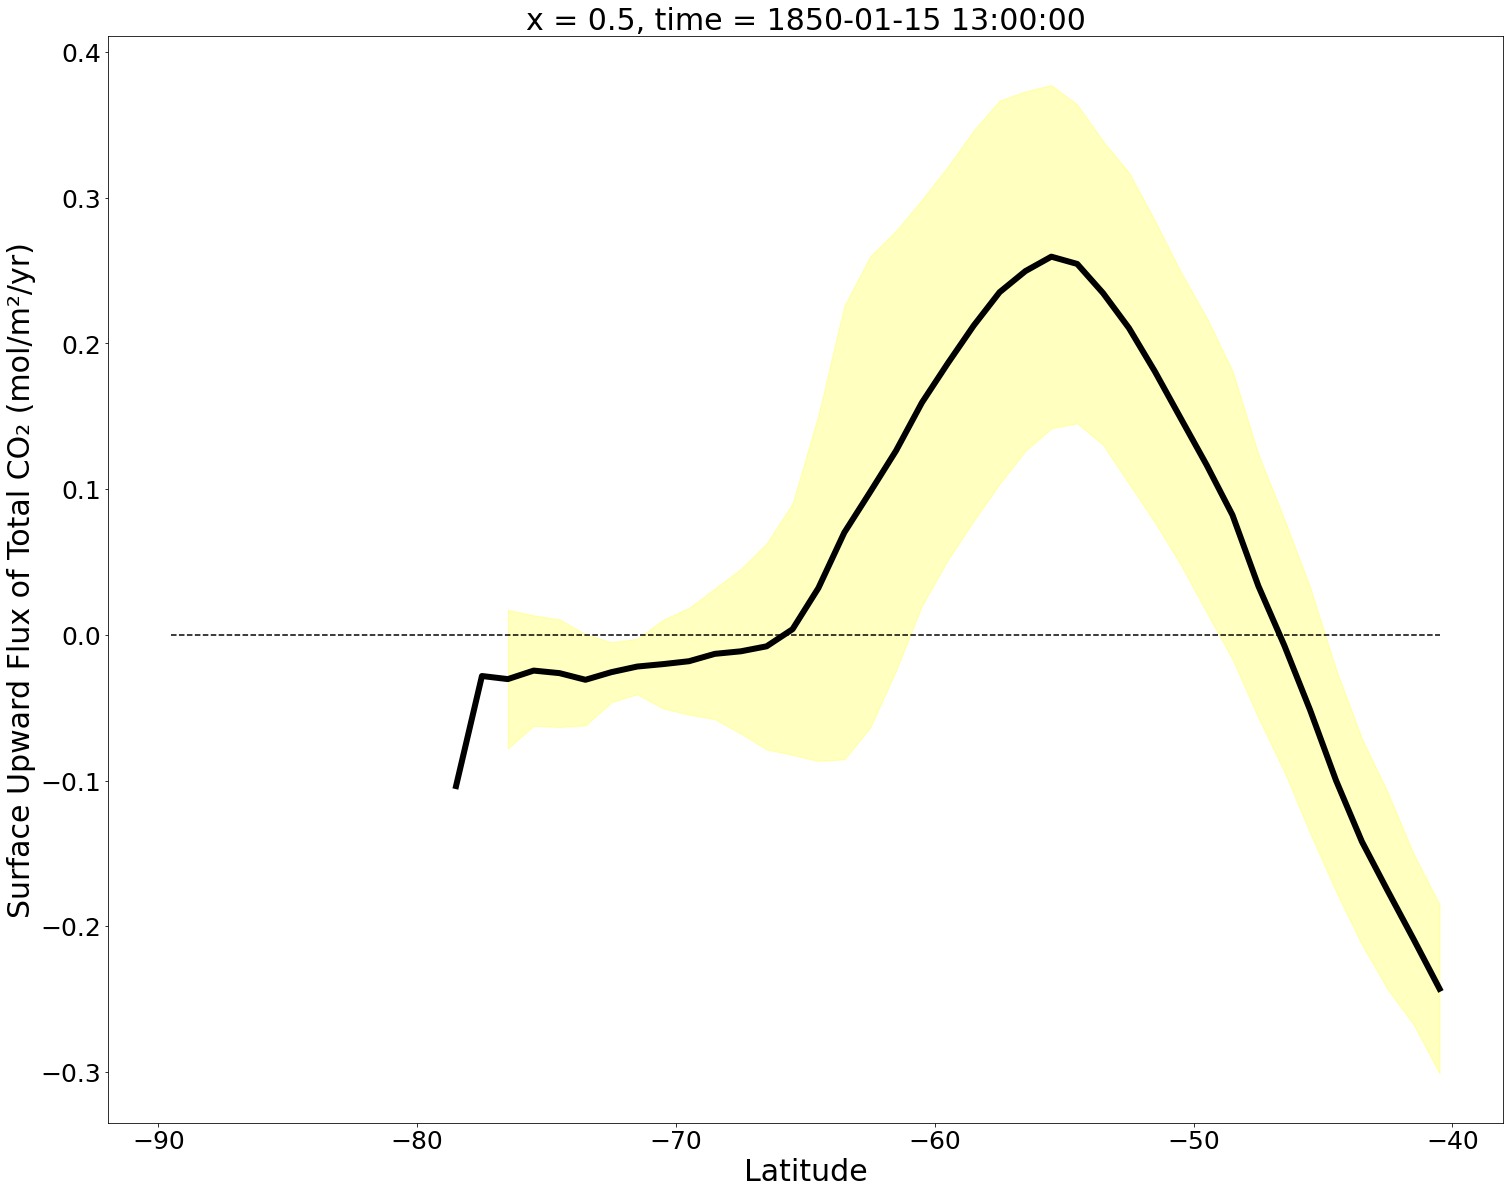

In [47]:
plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
# plt.plot(yy[0:50], mn[0:50]+sd[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
# plt.plot(yy[0:50], mn[0:50]-sd[0:50], lw = 6, label = 'Ensemble mean', color = 'black')
plt.fill_between(yy[0:50], mn[0:50]+sd[0:50], mn[0:50]-sd[0:50], color = 'yellow', alpha = 0.25)

zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')

In [58]:
# fig_1, axarr_1 = plt.subplots(nrows = 7, figsize=[18,12])
# plt.rc('font', size = 25)
# plt.rc('axes', titlesize= 30)    
# plt.rc('axes', labelsize= 30)
# plt.rc('figure', titlesize=30)
temp={}
yy = dd_new_new['CESM2-FV2.gr.historical.Omon'].lat.y

conversion = 3.1536e7 * 22.72
# 3.1536e7 seconds per year
# 22.72 mol CO2 per kg -- 44.01 gCO2/mol

# ax_idx = 0
# for name, ds in dd_new_new.items():
#     # maybe do mean over the entire circumference so just 
#     # take out the where function and mean all x
#     ar = -1*ds.fgco2.isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)*conversion
#     ds.fgco2.where(np.logical_and(ds.lon<=200, ds.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True).plot(label = name, lw = 3)
#     plt.plot(yy[0:50], ar[0:50], label = name, lw = 3)
#     # adds ar to an array 
#     temp[name] = ar
# #     print(ds.fgco2.lat.y)
#     plt.xlabel('Latitude')
#     plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')


mn = np.nanmean(list(temp.values()), axis=0)
plt.plot(yy[0:50], mn[0:50], lw = 6, label = 'Ensemble mean', color = 'black')


# sd = np.std(list(temp.values()), axis = 0)
# # plt.xlabel('Latitude')
# # plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# sd_up = mn+sd
# sd_down = mn-sd
# plt.fill_between(yy[0:50], sd_up[0:50], sd_down[0:50], color = 'yellow', alpha = 0.25)

# zr = xr.zeros_like(dd_new_new['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0, time = 0)[0:50].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)')
# # ax = plt.gca
# # box = ax.get_position()
# # ax.position([box.x0, box.y0, box.width * 0.8, box.height])
# plt.legend(
# #     bbox_to_anchor=(1.05, 1), 
#     loc='upper left'
# #     , borderaxespad=0.
# )
# plt.title('Circum Antarctic')
# # plt.rcParams["figure.figsize"] = (25,20)

IndexError: invalid index to scalar variable.

# PpCO2

In [12]:
# d = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time = slice(0, 239)).mean('time', keep_attrs=True)
dd_time_avg={}
for name,item in dd_new_new.items():
    if name != 'UKESM1-0-LL.gn.historical.Omon':
        dd_time_avg[name]=item.isel(time = slice(0, 239), lev = 16).mean('time', keep_attrs=True)

list(dd_time_avg.keys())

['MRI-ESM2-0.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [7]:
dd_time_avg={}
for name,item in dd_regrid.items():
    if name != 'UKESM1-0-LL.gn.historical.Omon':
        dd_time_avg[name]=item.isel(time = slice(0, 239), lev = 16).mean('time', keep_attrs=True)

dd_time_avg

{'CanESM5.gn.historical.Omon': <xarray.Dataset>
 Dimensions:     (bnds: 2, vertex: 4, x: 360, y: 180)
 Coordinates:
     lev         float64 322.0
     lev_bounds  (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
   * bnds        (bnds) int64 0 1
   * vertex      (vertex) int64 0 1 2 3
     lon         (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
     lat         (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
 Dimensions without coordinates: x, y
 Data variables:
     dissic      (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
     talk        (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
     fgco2       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
     so          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
     thetao      (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
 Attributes:
     regrid_method:  bilinear,
 'IPSL-CM6A-LR.gn.historical.Omo

In [ ]:
# ds = dd_time_avg['CESM2-FV2.gr.historical.Omon']
# ds['pressure'] = xr.zeros_like(ds['thetao'])
# p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)

# ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 

# conversion =  1e6/1035
# results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
#                     pressure_out=0, temperature_out = ds.thetao, pressure = p, 
#                     temperature = ds['insitutemp'])
# ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
# ds['pco2_out']

# ppco2={}
for name,ds in dd_time_avg.items():
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    print(name)
#     ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
#     ppco2[name] = ds['pco2_out']
    
# ppco2

CanESM5.gn.historical.Omon


The PpCO2 calculation is timing out for the regridded models. It fails at `results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])`. According to the cell above it worked for `CanESM5.gn.historical.Omon` but timed out sometime after that

In [ ]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_time_avg.items():
    
    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 800m'
    ax.set_title(title,fontsize=24,pad = 10)

    ds = ds.isel(lev = 16)
    # .sel(lev = 800, method = nearest)
#     ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    
#     Z = ds.pco2_out
    
#     lat = ds.lat.transpose('y','x')
#     lon = ds.lon.transpose('y','x')
#     X = lon
#     Y = lat
    
#     im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 200, vmax = 600)
    
#     cbar_label = 'Seawater Partial Pressure of CO2 (\u03BCatm)'
#     cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
#     cbar.set_label(cbar_label, fontsize = 16)
    
#     ax_idx += 1
    
#     print(surf)
#     lat = ds.lat.transpose('y','x')
# # #     print(lat)
#     lon = ds.lon.transpose('y','x')
#     draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
#                   title=name+ ' at 0m',
#                   plot_type='pcolormesh',clims=[300,500])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

In [ ]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():
    
    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 200m'
    ax.set_title(title,fontsize=24,pad = 10)

    ds = ds.isel(lev = 9, time = slice(0, 239)).mean('time', keep_attrs=True)
    # .sel(lev = 800, method = nearest)
#     ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    
    Z = ds.pco2_out
    
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 200, vmax = 600)
    
    cbar_label = 'Seawater Partial Pressure of CO2 (\u03BCatm)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 16)
    
    ax_idx += 1
#     print(surf)
#     lat = ds.lat.transpose('y','x')
# # #     print(lat)
#     lon = ds.lon.transpose('y','x')
#     draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
#                   title=name+ ' at 0m',
#                   plot_type='pcolormesh',clims=[300,500])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

In [ ]:
fig, axarr = plt.subplots(nrows = 5, ncols=3, figsize=[30,30], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 10)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():
    
    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
#     ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name+ ' at 100m'
    ax.set_title(title,fontsize=24,pad = 10)

    ds = ds.isel(lev = 6, time = slice(0, 239)).mean('time', keep_attrs=True)
    # .sel(lev = 800, method = nearest)
#     ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    
    Z = ds.pco2_out
    
    lat = ds.lat.transpose('y','x')
    lon = ds.lon.transpose('y','x')
    X = lon
    Y = lat
    
    im = ax.pcolormesh(X,Y,Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 200, vmax = 600)
    
    cbar_label = 'Seawater Partial Pressure of CO2 (\u03BCatm)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.07, pad=0.05)
    cbar.set_label(cbar_label, fontsize = 16)
    
    ax_idx += 1
#     print(surf)
#     lat = ds.lat.transpose('y','x')
# # #     print(lat)
#     lon = ds.lon.transpose('y','x')
#     draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
#                   title=name+ ' at 0m',
#                   plot_type='pcolormesh',clims=[300,500])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

In [19]:
print('kg/m\u2082')

kg/m₂
